# Preprocessing of Dataset

The existing dataset contains raw satelite imagery with dimensions and proportions which fail to fit the requirements of the model. This notebook will preprocess the data into 7 chunks of data representing random crops of the weather patterns over the UK. Crops are restricted to daylight hours only, from 8:00 AM - 4:55 PM.

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from tqdm import tqdm
import pathlib

plt.rcParams["figure.figsize"] = (20, 12)

In [2]:
SATELLITE_ZARR_PATH = "eumetsat_seviri_hrv_uk.zarr"

dataset = xr.open_dataset(
    SATELLITE_ZARR_PATH, 
    engine="zarr",
    chunks="auto",  # Load the data as a Dask array
)
dataset

<xarray.Dataset>
Dimensions:  (time: 173624, y: 891, x: 1843)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01T00:05:00 ... 2021-11-07T15:50:00
  * x        (x) float32 2.8e+04 2.7e+04 2.6e+04 ... -1.813e+06 -1.814e+06
    x_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
  * y        (y) float32 4.198e+06 4.199e+06 4.2e+06 ... 5.087e+06 5.088e+06
    y_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
Data variables:
    data     (time, y, x) int16 dask.array<chunksize=(22, 891, 1843), meta=np.ndarray>

The extent of the UK in this map is $[500,1012] \times [300,812]$, which is a 512 x 512 region. Therefore random crop will be pulled from mainly within this area.

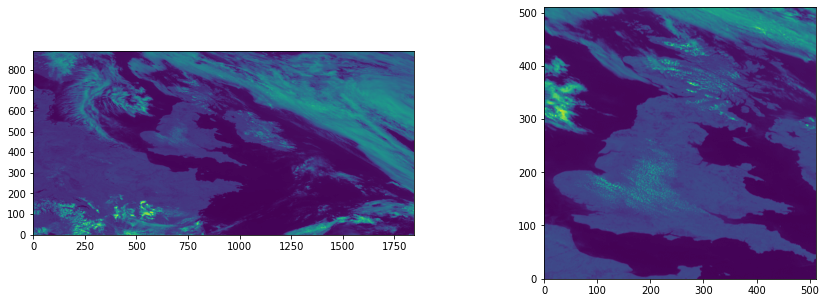

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].imshow(dataset["data"].sel(time="2020-06-01 12:00").to_numpy(), cmap='viridis', origin='lower')
ax[1].imshow(dataset["data"].sel(time="2020-06-01 12:00").isel(x=slice(500, 1012), y=slice(300, 812)).to_numpy(), cmap='viridis', origin='lower')

On the left is the whole satelite image, and on the right is the 512 by 512 crop from which the images of weather over the UK will be pulled.

Here is the procedure:
1. For each 3 hr period per day
    1. Select 5 random centers in the region $[628, 884] \times [428,684]$
    2. Crop the 128 x 128 region around that center to get the input sequence
    3. Crop the 64 x 64 region around that center to get the output sequence

In [3]:
def random_center(num=5):
    xs = np.random.randint(628, 885, size=(num, 1))
    ys = np.random.randint(428, 685, size=(num, 1))
    return np.hstack((xs, ys))


def get_bounds(cx, cy, length=128):
    return cx - length // 2, cx + length // 2, cy - length // 2, cy + length // 2


def gen_sequence(
    cx: int,
    cy: int,
    data: np.ndarray,
    img_size: int,
    seq_length: int,
    start_idx: int,
):
    sx, ex, sy, ey = get_bounds(cx, cy, img_size)

    for i in range(seq_length):
        yield data[start_idx + i, sy:ey, sx:ex]


def gen_example(cx: int, cy: int, data: np.ndarray, start_idx: int):
    x = gen_sequence(cx, cy, data, 128, 12, start_idx)
    y = gen_sequence(cx, cy, data, 64, 24, start_idx + 12)
    return np.dstack(tuple(x)), np.dstack(tuple(y))


However, pulling these from the `xarray` dataset is slow (1 min, 30 sec) per draw. Therefore a preprocessing step to NumPy binaries is added.

Starting on February 2nd, 2020, the following pattern is used to process blocks of data:
1. Start at 8:00 AM every morning.
2. Select the the next 9 hours of satelite imagery and write to file (to avoid overloading RAM). Each of these blocks rounds out to 300 MB.
2. Skip forward 3 days and repeat. Repeat until the dataset is exhausted. This corresponds to selecting ~200 days worth of imagery, and a total of 60 GB of data of the total uncompressed ~500 GB of data. If more data is needed, this can be scaled up to more frequent measurements.

In [6]:
def generate_blocks(path: pathlib.Path, start_time:int, skip_time:int, selection_region:int):
    if not path.exists():
        path.mkdir(parents=True)
    for i in tqdm(range(start_time, 173264, skip_time)):
        block = dataset.isel(time=slice(i, i + selection_region)).to_array().to_numpy()
        newpath = path / f"block{i//skip_time}.npy"
        np.save(newpath, block)
        del block


path = pathlib.Path("./temp/blocks/")
start_time = 1823
skip_time = 864
selection_region = 108

generate_blocks(path, start_time, skip_time, selection_region)

100%|██████████| 199/199 [33:06<00:00,  9.98s/it]


Each block created contains 6 three-hour periods over which an input-output pair of image sequences can be generated. From each of those 3 hour periods, the large image can be cropped using the utilities above. For this processing, 10 crops were chosen per 3 hour period. Therefore per block, there are 6*10 = 60 input-output pairs for the model to use. In total, this amounts to 11940 total examples that can be utilized in model training/testing. 

The blocks are grouped into multiple batches to make splitting into training and testing sets easier and more accessible. 

In [15]:
import math

def generate_examples(temppath: pathlib.Path, batches=3, num_centers=10):
    xs, ys = [], []
    examplepath = temppath / "examples"
    blockpath = temppath / "blocks"
    num_blocks = len([e for e in blockpath.iterdir()])

    if not examplepath.exists():
        examplepath.mkdir(parents=True)

    num_examples = num_blocks * num_centers * 6
    batch_size = int(math.ceil(num_examples/batches))
    example_idx = 0
    
    for i in tqdm(range(2, num_blocks+2)):
        block = np.load(blockpath/f"block{i}.npy")[0]
        for start in range(0, 72, 12):
            centers = random_center(num_centers)
            for cx, cy in centers:
                x, y = gen_example(cx, cy, block, start)
                xs.append(x)
                ys.append(y)
                example_idx += 1
                if example_idx % batch_size == 0:
                    inputs = np.array(xs)
                    outputs = np.array(ys)
                    np.savez(
                        examplepath / f"batch{example_idx // batch_size}.npz",
                        xs=inputs,
                        ys=outputs,
                    )
                    xs.clear()
                    ys.clear()
        del block
    if len(xs) != 0:
        inputs = np.array(xs)
        outputs = np.array(ys)
        np.savez(
            examplepath / f"batch{example_idx // batch_size}.npz",
            xs=inputs,
            ys=outputs,
        )

In [16]:
path = pathlib.Path("./temp/")
generate_examples(path, batches=10, num_centers=10)

100%|██████████| 199/199 [08:33<00:00,  2.58s/it]


To load one of these batches, it is simple enough to use `np.load` and extract the inputs and outputs.

In [17]:
with np.load("./temp/examples/batch4.npz") as data:
    x = data["xs"]
    y = data["ys"]

In [20]:
print(x.shape)
print(y.shape)

(1194, 128, 128, 12)
(1194, 64, 64, 24)


Loading the input sequence below

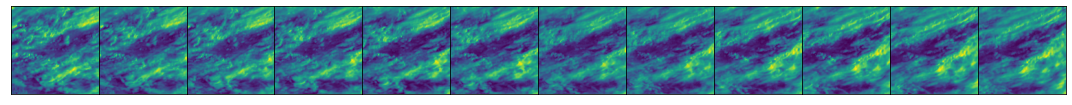

In [21]:
fig, ax = plt.subplots(1, 12, figsize=(15,5))
for i in range(12):
    ax[i].imshow(x[11,:,:,i], cmap='viridis')
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

And visualizing the corresponding output sequence below

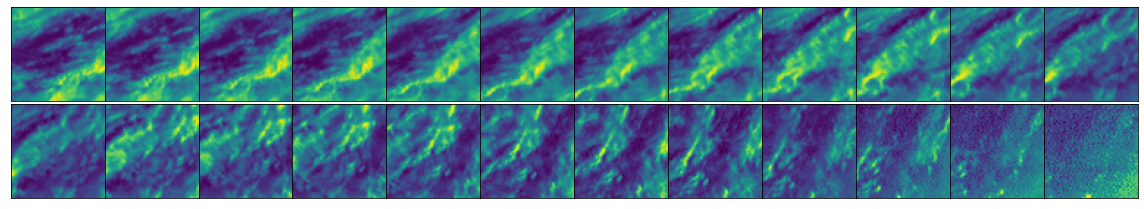

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 12, figsize=(16,3))
for i in range(12):
    ax1[i].imshow(y[11,:,:,i], cmap='viridis')
    ax1[i].get_xaxis().set_visible(False)
    ax1[i].get_yaxis().set_visible(False)

for i in range(12):
    ax2[i].imshow(y[11,:,:,12+i], cmap='viridis')
    ax2[i].get_xaxis().set_visible(False)
    ax2[i].get_yaxis().set_visible(False)

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)